**Assignment – Model Selection**

Do the following on titanic dataset
1. Load the dataset into python environment
2. Do all the necessary pre-processing steps
3. Create kNN and SVM models
4. Do k-fold and stratified stratified k-fold cross validation techniques and find the
average accuracy score of the models


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Q1.First we load the dataset.

In [2]:
data=pd.read_csv('/content/titanic_dataset new.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.shape

(891, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Q2.**Data Preprocessing**

Handling Missing Values

In [6]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Since age is a numerical column,let us replace nan values with median.

In [7]:
data['Age'].fillna(data['Age'].median(),inplace=True)

Since cabin and embarked are categorical columns,let us replace nan values with mode.

In [8]:
data['Cabin'].fillna(data['Cabin'].mode()[0],inplace=True)

In [9]:
data['Embarked'].fillna(data['Embarked'].mode()[0],inplace=True)

In [10]:
data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Managing Outliers

Let us visualise numerical columns age and fare to identify outliers.

<Figure size 1500x600 with 0 Axes>

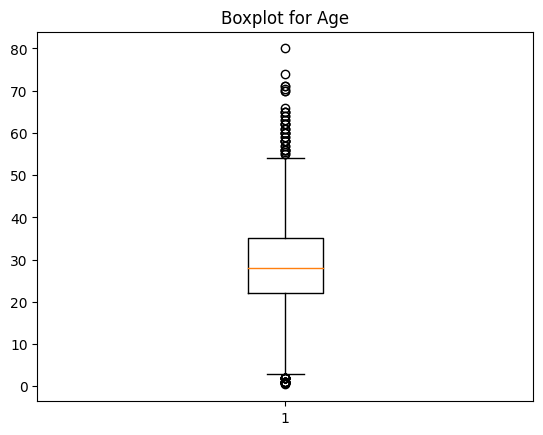

<Figure size 1500x600 with 0 Axes>

In [11]:
plt.boxplot(data['Age'])
plt.title('Boxplot for Age')
plt.figure(figsize=(15,6))

<Figure size 1500x600 with 0 Axes>

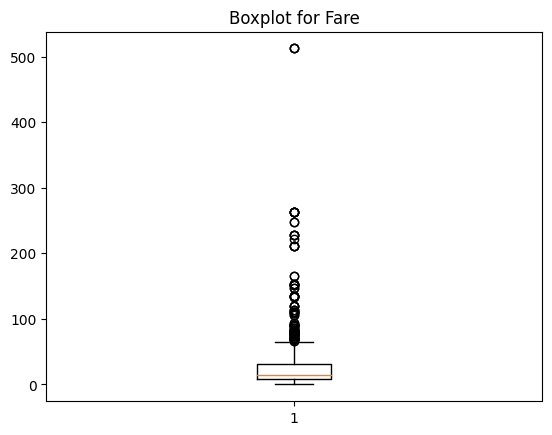

<Figure size 1500x600 with 0 Axes>

In [12]:
plt.boxplot(data['Fare'])
plt.title('Boxplot for Fare')
plt.figure(figsize=(15,6))

Both Age and Fare contain outliers. Let's find which valuers are the outliers

In [13]:
# first we plot the distributions to find out if they are Gaussian or skewed.

Text(0.5, 0, 'Fare')

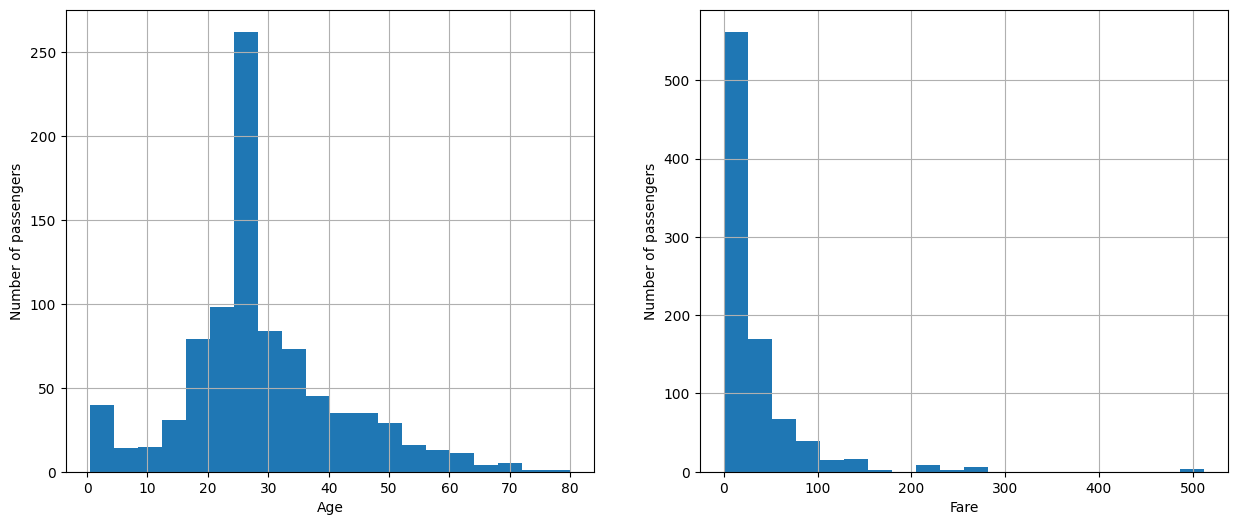

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = data.Age.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel('Age')

plt.subplot(1, 2, 2)
fig = data.Fare.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel('Fare')

In [15]:
##Age is quite Gaussian and Fare is skewed, so I will use the Gaussian assumption for Age, and the interquantile range for Fare.

In [16]:
# find outliers

# Age
Upper_boundary = data.Age.mean() + 3* data.Age.std()
Lower_boundary = data.Age.mean() - 3* data.Age.std()
print('Age outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_boundary, upperboundary=Upper_boundary))

# Fare
IQR = data.Fare.quantile(0.75) - data.Fare.quantile(0.25)
Lower_fence = data.Fare.quantile(0.25) - (IQR * 3)
Upper_fence = data.Fare.quantile(0.75) + (IQR * 3)
print('Fare outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Age outliers are values < -9.697507161337114 or > 68.42067214450209
Fare outliers are values < -61.358399999999996 or > 100.2688


In [17]:
# top-coding the Age variable

data.loc[data.Age>68, 'Age'] = 68
data.loc[data.Age>68, 'Age'] = 68

data.Age.max(),data.Age.max()

(68.0, 68.0)

In [18]:
# top-coding: capping the variable Fare at 100
data.loc[data.Fare>100, 'Fare'] = 100
data.loc[data.Fare>100, 'Fare'] = 100
data.Fare.max(), data.Fare.max()

(100.0, 100.0)

In [19]:
data['PassengerId'].nunique()




891

In [20]:
data['Name'].nunique()

891

Drop Irrelevant columns

In [21]:
data = data.drop(['PassengerId', 'Name'], axis=1)

Label encoding for object type.

In [22]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,B96 B98,S


In [23]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['Sex']=le.fit_transform(data['Sex'])
data['Ticket']=le.fit_transform(data['Ticket'])
data['Cabin']=le.fit_transform(data['Cabin'])
data['Embarked']=le.fit_transform(data['Embarked'])

Now we check correlation.

<Axes: >

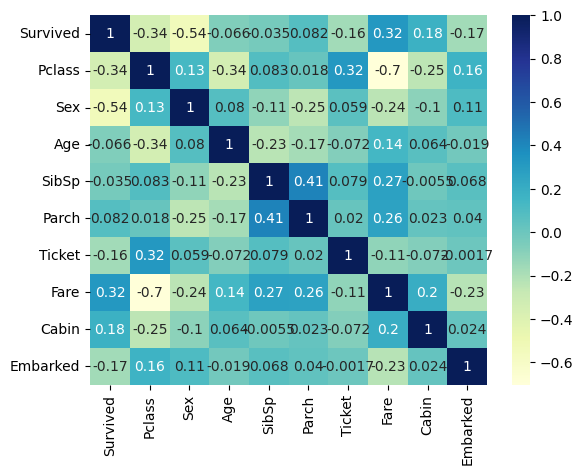

In [24]:
corr_matrix=data.corr()
sns.heatmap(corr_matrix,annot=True,cmap='YlGnBu')

In [25]:
# Scale numerical features using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[['Age', 'Fare']] = scaler.fit_transform(data[['Age', 'Fare']])

In [26]:
# Split the dataset into features (X) and target (y)
X = data.drop(['Survived','Ticket'], axis=1)
y = data['Survived']

KNN model

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [29]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

In [30]:
metric_k=[]##create an empty list.
neighbors=np.arange(3,15)

In [31]:
for k in neighbors:
  KNN_model=KNeighborsClassifier(n_neighbors=k,metric='euclidean')
  KNN_model.fit(x_train,y_train)
  y_predictions=KNN_model.predict(x_test)
  acc=accuracy_score(y_test,y_predictions)
  metric_k.append(acc)

In [32]:
metric_k

[0.7486033519553073,
 0.7597765363128491,
 0.776536312849162,
 0.776536312849162,
 0.8044692737430168,
 0.7877094972067039,
 0.7932960893854749,
 0.7932960893854749,
 0.7877094972067039,
 0.7821229050279329,
 0.7877094972067039,
 0.7821229050279329]

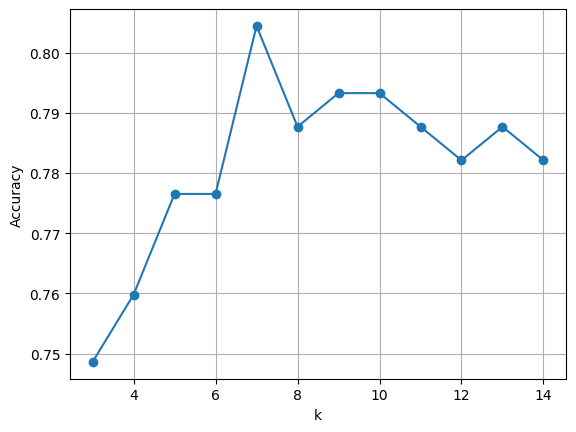

In [33]:
plt.plot(neighbors,metric_k,'o-')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid()

In [34]:
 KNN_model=KNeighborsClassifier(n_neighbors=7,metric='euclidean')
 KNN_model.fit(x_train,y_train)
 y_predictions=KNN_model.predict(x_test)

In [35]:
print('Accuracy=',accuracy_score(y_test,y_predictions))
print('Precision=',precision_score(y_test,y_predictions))
print('Recall=',recall_score(y_test,y_predictions))
print('f1 score=',f1_score(y_test,y_predictions))
confusion_matrix(y_test,y_predictions)

Accuracy= 0.8044692737430168
Precision= 0.7671232876712328
Recall= 0.7567567567567568
f1 score= 0.761904761904762


array([[88, 17],
       [18, 56]])

SVM model

In [36]:
from sklearn.svm import SVC
svm_model=SVC(kernel='linear')
svm_model.fit(x_train,y_train)

SVC(kernel='linear')

In [37]:
y_pred=svm_model.predict(x_test)

In [38]:
print('Accuracy=',accuracy_score(y_test,y_predictions))
print('Precision=',precision_score(y_test,y_predictions))
print('Recall=',recall_score(y_test,y_predictions))
print('f1 score=',f1_score(y_test,y_predictions))
confusion_matrix(y_test,y_predictions)

Accuracy= 0.8044692737430168
Precision= 0.7671232876712328
Recall= 0.7567567567567568
f1 score= 0.761904761904762


array([[88, 17],
       [18, 56]])

K Fold Cross Validation

In [39]:
from sklearn.model_selection import KFold
Kfold_validator=KFold(10)

In [41]:
from sklearn.model_selection import cross_val_score
Kfold_cv_result_KNN=cross_val_score(KNN_model,X,y,cv=Kfold_validator)

In [42]:
Kfold_cv_result_KNN

array([0.74444444, 0.73033708, 0.75280899, 0.70786517, 0.80898876,
       0.78651685, 0.7752809 , 0.7752809 , 0.82022472, 0.7752809 ])

In [43]:
np.mean(Kfold_cv_result_KNN)

0.7677028714107366

Stratified Cross Validation

In [44]:
from sklearn.model_selection import StratifiedKFold
skfold_validator=StratifiedKFold(n_splits=10)

In [46]:
Stratified_cv_result_KNN=cross_val_score(KNN_model,X,y,cv=skfold_validator)
Stratified_cv_result_KNN

array([0.74444444, 0.74157303, 0.71910112, 0.70786517, 0.84269663,
       0.7752809 , 0.78651685, 0.76404494, 0.82022472, 0.7752809 ])

In [47]:
np.mean(Stratified_cv_result_KNN)

0.7677028714107367